### Tanzinian Water Pump Classification ###

### Exploritory Data Analysis

This notebook will show how we determine which features to use. 
We will explore the relationships between the features and target data as well as a look at our feature engineering. 

In [231]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle 
import numpy as np
from scipy.stats import chi2_contingency
import scipy.stats as stats

from pylab import savefig

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None

from shapely.geometry import Point,Polygon
import geopandas as gpd
import descartes

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

plt.style.use('ggplot')

In [5]:
df = pd.read_pickle('Pclean_df.pkl')

### Feature Managment 

We know that not all of these will be helpful features, and that is was EDA is all about. 
Let's take a look at the columns. 


We have a lot of columns to work through, so as we go through them, we will start a list of columns to drop. For example, 'id' is not a relevant predictor, so we will add it to the list. 
Additionally if we have the date_recorded, we already know if it is functional or needs repairs, so we will also drop that column. 

In [6]:
dropcols = ['id', 'date_recorded', 'recorded_by']

### dropcols

- ['id']
- ['date_recorded']
- ['recorded_by']
- ['wpt_name']
- ['source_type']
- ['source_class'] 
- ['waterpoint_type_group'] 
- ['payment']
- ['scheme_name']
- ['quantity_group']
- ['extraction_type_group'] 
- ['extraction_type_class']
- ['management_group']
- ['region_code']

### Continuous Features 

- ['amount_tsh']
- ['gps_height']
- ['longitude'] & ['latitude']
- ['population']
- ['construction_year']

### Catergorical Features

- ['funder']
- ['installer'] 
- ['quantity']
- ['quality_group'] 
- [ 'water_quality']
- ['payment_type']
- ['source']
- ['waterpoint_type']
- ['num_private']
- ['extraction_type']
- ['scheme_management'] 
- ['management'] 
- ['public_meeting']
- ['permit']

Location Based Engineering

- ['basin']
- ['region'] 
- ['district_code'] 
- ['lga'] (local goverment areas)
- ['ward']
- ['subvillage']

Target 
- ['status_group']

For catergorical features like we saw in the data cleaning of funder, we need to make sure they are all lowercase for better manipulation. 

In [7]:
text_feats = ['funder', 'installer', 'wpt_name', 'basin', 
 'subvillage', 'region', 'lga', 'ward',  
 'scheme_management', 'scheme_name', 'extraction_type',
 'extraction_type_group', 'extraction_type_class', 'management',
 'management_group', 'payment', 'payment_type', 'water_quality',
 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
 'source_class', 'waterpoint_type', 'waterpoint_type_group']

for c in text_feats:
    df[c] = [x.lower() for x in df[c]]

## Visualizations and Finding Relationships

Below we start with a look at the status_groups. This does show what we already know in that
the classes are imbalanced with functional needs repair as the smallest class. 

### Target
#### ['status_group']

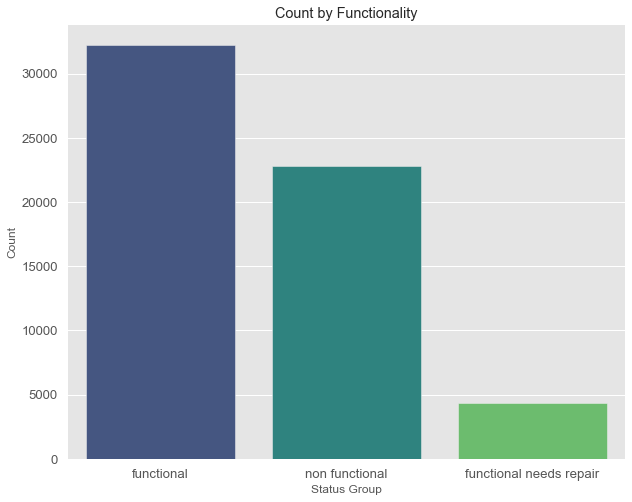

In [239]:
fig = plt.figure(figsize = (10, 8))
sns.countplot(df.status_group, palette = 'viridis')


plt.title('Count by Functionality')
plt.xlabel('Status Group')
plt.ylabel('Count')
plt.show()

filename = ('class_imbalance')
fig.savefig(filename)

### Amount TSH - Continuous 
#### ['amount_tsh'] vs ['status_group']

In [239]:
#df[df['status_group'] == 'non functional']['amount_tsh'].value_counts()

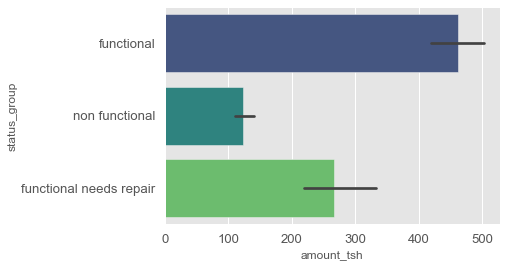

In [226]:
sns.barplot(x = 'amount_tsh', y = 'status_group', data = df, palette = 'viridis')
plt.show()

### GPS Height - Continuous 
#### ['gps_height'] vs ['status_group'] 

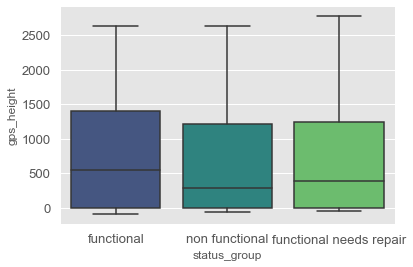

In [227]:
sns.boxplot(x = 'status_group', y = 'gps_height', data = df, palette = 'viridis')
plt.show()

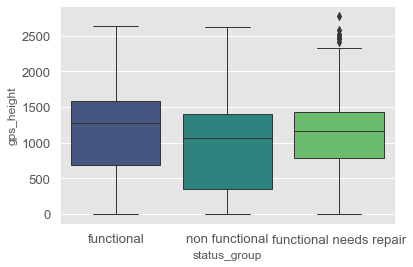

In [228]:
# took out zero values
sns.boxplot(x = 'status_group', y = 'gps_height', 
            data = df[df.gps_height > 0], linewidth = 1, palette = 'viridis')
plt.show()

In [243]:
import scipy.stats as st
st.ttest_ind(df[(df.gps_height > 0) & (df.status_group == 'functional')].gps_height, 
             df[(df.gps_height > 0) & (df.status_group == 'non functional')].gps_height)

#Our independent t test does show there is statistical significance between functional and non-functional. 

Ttest_indResult(statistic=30.600722658837718, pvalue=5.754674377100651e-203)

### Funder and Installer
#### ['funder']/['installer'] vs ['status_group']

Looking at the funders and the installers of the wells, I imagined turning these into dummy variables would be helpful. 
However, given the number of these groups, we decided that funder/installer with 100 or more listings we could keep and turn into dummies. 



In [244]:
#list(df['funder'].sort_values(ascending = False).unique())

In [245]:
other_funders = [x for x in set(df.funder) if len(df[df.funder == x]) < 100]
df['funder'] = np.where(df.funder.isin(other_funders), 'others', df.funder)

In [246]:
other_installer = [x for x in set(df.installer) if len(df[df.installer == x]) < 100]
df['installer'] = np.where(df.installer.isin(other_installer), 'others', df.installer)

### Latitude and Longitude
#### ['latitude']/['longitude'] vs ['status_group']

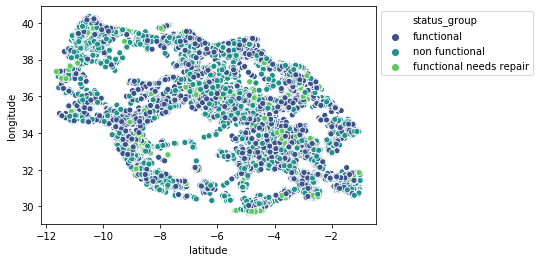

In [17]:
svm = sns.scatterplot(x = 'latitude', y = 'longitude', data = df, hue = 'status_group', palette = 'viridis')
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

figure = svm.get_figure()    
figure.savefig('gps_height.png', dpi=400)

In [248]:
# Geo Pandas Here


### WPT Name / Num Private 
#### ['wpt_name']/['num_private'] vs ['status_group']

WPT is the "water point name", this should have no effect on the target itself and should be removed. 

In [249]:
dropcols = dropcols + ['wpt_name']

Num_Private I don't know exactly what this is but the overwhelming majority show 0. 
For now we have opted to leave this as is and see what we may want to do with it later. 

In [250]:
df['num_private'].value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

## Locations

### Basin / Subvillage / Region / Region Code / District Code / Ward 

#### ['basin']/['subvillage']/['region']/['region_code']/['district_code']/['ward']/['lga'] vs ['status_group']

We have a lot of location information. 
The basin is where the water is coming from. 
There are 31 regions of Tanzania were divided into 169 districts.
From there the districts are further divided into wards or county like areas.
Subvillages are the breakdown in neighborhoods. 

#### 31 Regions > 169 Districs (as of 2012) > Wards (counties) > Subvillages (smaller neighborhoods) 

#### Basin

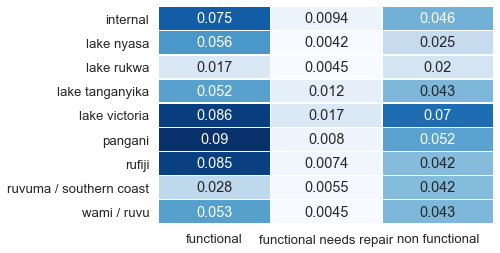

In [157]:
ct = pd.crosstab(df.basin, df.status_group,normalize = True)
sns.heatmap(ct, annot = True, linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [252]:
df.basin.unique()

array(['lake nyasa', 'lake victoria', 'pangani',
       'ruvuma / southern coast', 'internal', 'lake tanganyika',
       'wami / ruvu', 'rufiji', 'lake rukwa'], dtype=object)

In [253]:
from geopy.geocoders import Nominatim

def get_lat_long(location):
    geolocator = Nominatim(user_agent = "Tanzwater")
    location = geolocator.geocode(location)
    return (location.latitude, location.longitude)

In [254]:
#basin lat and long
basins = set(df.basin)
allbasins = dict.fromkeys(basins, ())
for bas in basins:
    try:
        allbasins[bas] = get_lat_long(bas)
    except AttributeError:
        print(f'error: {bas}')

error: wami / ruvu
error: ruvuma / southern coast


In [255]:
# manually adding ones that threw error
allbasins['wami / ruvu'] = (-6.8176, 37.6604)
allbasins['ruvuma / southern coast'] = (-11.25, 38.31)

In [256]:
df['basin_lat'] = df.basin.apply(lambda x: allbasins[x][0])
df['basin_long'] = df.basin.apply(lambda x: allbasins[x][1])


### New Feature Distance to Basin

In [257]:
from geopy.distance import geodesic

def get_dist(crd1, crd2): 
    return geodesic(crd1, crd2).miles

In [258]:
df['dist_to_basin'] = df.apply(lambda x: get_dist((x.latitude, x.longitude), 
                            (x.basin_lat, x.basin_long)), axis = 1)

In [259]:
df[df.status_group == 'functional'].region.value_counts()

iringa           4141
shinyanga        2789
kilimanjaro      2640
mbeya            2319
arusha           2294
morogoro         2119
kagera           1727
pwani            1556
mwanza           1502
ruvuma           1480
tanga            1436
kigoma           1363
singida          1011
dodoma           1009
manyara           987
mara              886
tabora            848
rukwa             707
mtwara            524
dar es salaam     461
lindi             460
Name: region, dtype: int64

In [260]:
df[df.status_group == 'non functional'].region.value_counts()

mbeya            1816
morogoro         1587
shinyanga        1558
kilimanjaro      1417
mwanza           1417
kagera           1285
mtwara           1080
tabora           1066
pwani            1043
tanga            1038
iringa           1030
mara             1023
ruvuma            996
lindi             993
dodoma            983
rukwa             966
singida           954
arusha            881
kigoma            850
manyara           500
dar es salaam     341
Name: region, dtype: int64

#### Region vs Region Code

Region has a few more values than region code. We opted to drop region code. 

In [261]:
dropcols = dropcols + ['region_code']

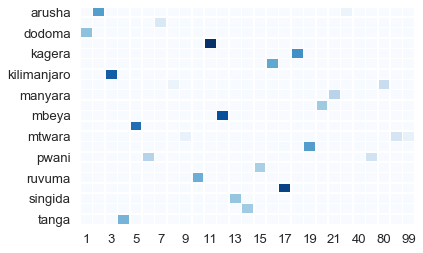

In [262]:
ct = pd.crosstab(df['region'], df['region_code'],normalize = True)
sns.heatmap(ct, linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [263]:
print(len(df.region.unique()))
print(len(df.region_code.unique()))

21
27


In [264]:
# convert region_code and district_code to be objects.
df['region_code'] = df.region_code.astype('object')
df['district_code'] = df.district_code.astype('object')

#### Subvillage

There are way too many subvillages to divide into catergorical features. 

In [265]:
len(df.subvillage.unique())

19287

In [266]:
subvil_counts = df.subvillage.value_counts()

In [267]:
# new column: n_wells_village
cond = [subvil_counts[df.subvillage] > 300, 
        subvil_counts[df.subvillage] > 100,
        subvil_counts[df.subvillage] > 50, subvil_counts[df.subvillage] > 10]
vals = ['more_than_300', 'more_than_100', 'more_than50', 'more_than_10']
df['n_wells_village'] = np.select(cond, vals, 'less_than_10')

In [268]:
# turn less than 100 wells village into 'others'
other_subvill =  [x for x in set(df.subvillage) if len(df[df.subvillage == x]) < 100]
df['subvillage'] = np.where(df.subvillage.isin(other_subvill), 'others', df.subvillage)

In [269]:
df['subvillage'].value_counts()

others        54482
madukani        508
shuleni         506
majengo         502
kawawa          438
kati            373
mtakuja         262
sokoni          232
m               187
muungano        172
mbuyuni         164
mlimani         152
songambele      147
1               142
msikitini       134
miembeni        134
kibaoni         114
kanisani        111
mapinduzi       109
i               109
mjimwema        108
mjini           108
mkwajuni        104
mwenge          102
Name: subvillage, dtype: int64

#### Ward

Way too many wards to catergorize.


In [270]:
sum(df.ward.value_counts() > 200)

8

In [271]:
df['urban'] = df.ward.str.contains('urban')

In [272]:
dropcols = dropcols + ['ward']

#### LGA
(local government areas)

In [273]:
df.lga.unique()

array(['ludewa', 'serengeti', 'simanjiro', 'nanyumbu', 'karagwe',
       'mkinga', 'shinyanga rural', 'kahama', 'tabora urban', 'mkuranga',
       'namtumbo', 'maswa', 'siha', 'meatu', 'sumbawanga rural', 'njombe',
       'ukerewe', 'bariadi', 'same', 'kigoma rural', 'moshi rural',
       'lindi rural', 'rombo', 'chamwino', 'bagamoyo', 'mafia',
       'arusha rural', 'kyela', 'kondoa', 'kilolo', 'kibondo', 'makete',
       'singida rural', 'masasi', 'rungwe', 'moshi urban', 'geita',
       'mbulu', 'bukoba rural', 'muheza', 'lushoto', 'meru', 'iramba',
       'kilombero', 'mbarali', 'kasulu', 'bukoba urban', 'korogwe',
       'bukombe', 'morogoro rural', 'kishapu', 'musoma rural',
       'sengerema', 'iringa rural', 'muleba', 'dodoma urban', 'ruangwa',
       'hanang', 'misenyi', 'missungwi', 'songea rural', 'tanga',
       'tunduru', 'hai', 'mwanga', 'chato', 'biharamulo', 'ileje',
       'mpwapwa', 'mvomero', 'bunda', 'kiteto', 'longido', 'urambo',
       'mbozi', 'sikonge', 'ilala',

In [274]:
#df.distance_lga_canter = df.lga 

### Population
#### ['population'] vs ['status_group']

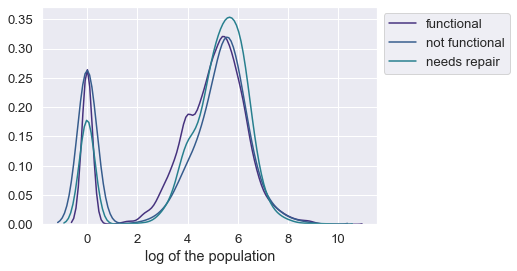

In [158]:
zero = df[df.population!=0]
sns.set_palette('viridis')
sns.distplot(np.log(zero[zero.status_group == 'functional'].population), hist = False, 
            label='functional')
sns.distplot(np.log(zero[zero.status_group == 'non functional'].population), hist = False, 
            label = 'not functional')
sns.distplot(np.log(zero[zero.status_group == 'functional needs repair'].population), hist = False, 
            label = 'needs repair')

plt.xlabel('log of the population')
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

In [ ]:
fig2 = plt.figure(figsize=(15,10))
sns.boxplot(x = zero.status_group, y = np.log(zero.population), color = 'viridis')
plt.xlabel('well status')
plt.show();

In [277]:
df.groupby(['region'])['population'].sum()

region
arusha            878501
dar es salaam     193879
dodoma                 0
iringa            499247
kagera                 0
kigoma           1408681
kilimanjaro       463070
lindi             563370
manyara           503043
mara             1060886
mbeya                  0
morogoro         1060090
mtwara            462674
mwanza            202610
pwani             920896
rukwa             661359
ruvuma            525411
shinyanga          70251
singida           584203
tabora                 0
tanga             628482
Name: population, dtype: int64

In [278]:
ct = pd.crosstab(df.status_group, df.region)

### Public Meeting 
#### ['public_meeting'] vs ['status_group']

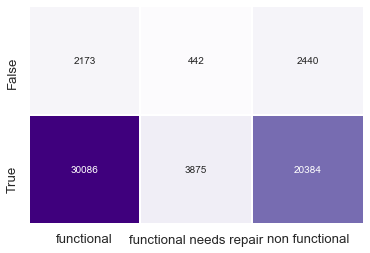

In [279]:
ct = pd.crosstab(df.public_meeting, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Purples')
plt.xlabel('')
plt.ylabel('')
plt.show()

### Scheme Management / Scheme Name
#### ['scheme_managment']/['scheme_name'] vs ['status_group']

Scheme name doesn't seem particuarly relevant, so I will drop that. 

In [280]:
dropcols = dropcols + ['scheme_name']

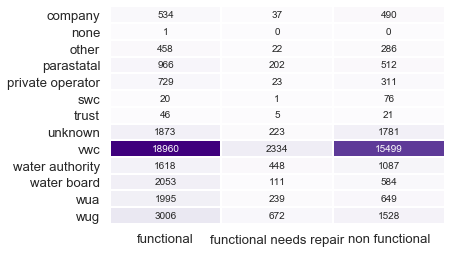

In [281]:
ct = pd.crosstab(df.scheme_management, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Purples')
plt.xlabel('')
plt.ylabel('')
plt.show()

### Permit 
#### ['permit'] vs ['status_group']

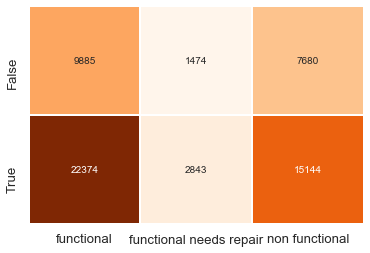

In [282]:
ct = pd.crosstab(df.permit, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Oranges')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [283]:
contingency_table = pd.crosstab(
    df.status_group,
    df.permit,
    margins = True)
contingency_table

permit,False,True,All
status_group,,,
functional,9885,22374,32259
functional needs repair,1474,2843,4317
non functional,7680,15144,22824
All,19039,40361,59400


In [284]:
f_obs = np.array([contingency_table.iloc[0][0:2].values,
                  contingency_table.iloc[1][0:2].values,
                 contingency_table.iloc[2][0:2].values])
f_obs

array([[ 9885, 22374],
       [ 1474,  2843],
       [ 7680, 15144]])

In [285]:
print(stats.chi2_contingency(f_obs)[0:3])

(64.81932717842754, 8.40740450029323e-15, 2)


Chi Square test of independence shows there is significance. 

### Construction Year - Continuous
#### ['construction_year'] vs ['status_group']

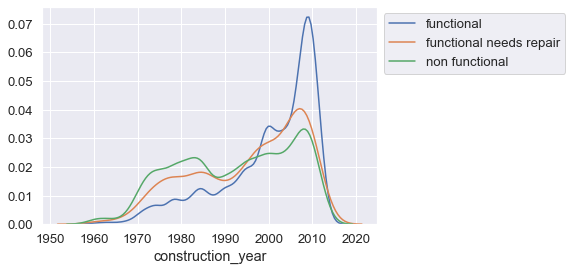

In [286]:
zeros = df[df.construction_year!=0]
sns.distplot(zeros[zeros['status_group'] == 'functional'].construction_year, hist = False, label = 'functional')
sns.distplot(zeros[zeros['status_group'] == 'functional needs repair'].construction_year, hist = False, label = 'functional needs repair')
sns.distplot(zeros[zeros['status_group'] == 'non functional'].construction_year, hist = False, label = 'non functional')

plt.legend(bbox_to_anchor = [1, 1])
plt.show()

Built in the last 60 years by decade.
Max year is 2013, Min year 1960, there are a lot of zero values, so we will bin the years from the 1960s to the 2010s. 
Other values will be listed as other. 

In [ ]:
cond = [df.construction_year > 2010, 
       df.construction_year > 2000, 
       df.construction_year > 1990, 
       df.construction_year > 1980,
       df.construction_year > 1970,
       df.construction_year > 1960]
vals = ['10s','00s', '90s', '80s', '70s', '60s']
df['built_recent'] = np.select(cond, vals, 'others')

In [ ]:
sns.barplot(x = 'built_recent', y = 'status_group', data = df)

### Extraction Type / Extraction Type Group / Extraction Type Class
#### ['extraction_type']/['extraction_type_group']/['extraction_type_class'] vs ['status_group']

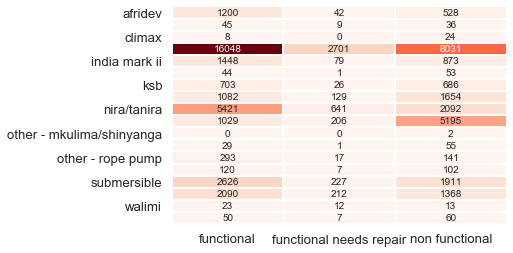

In [288]:
ct = pd.crosstab(df.extraction_type, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Reds')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [289]:
print('extraction_type_class:', len(df.extraction_type_class.unique()))
print('extraction_type_group:', len(df.extraction_type_group.unique()))
print('extraction_type:', len(df.extraction_type.unique()))

extraction_type_class: 7
extraction_type_group: 13
extraction_type: 18


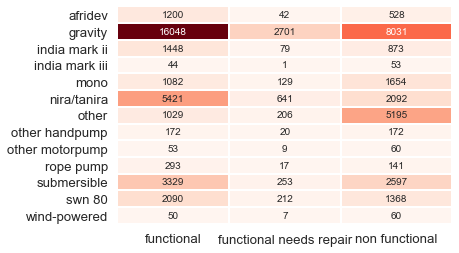

In [290]:
ct = pd.crosstab(df.extraction_type_group, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Reds')
plt.xlabel('')
plt.ylabel('')
plt.show()

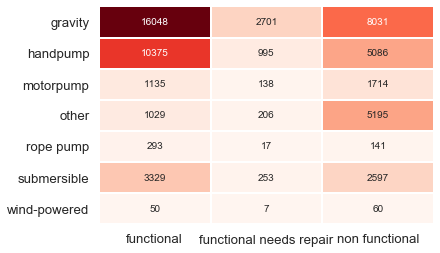

In [291]:
ct = pd.crosstab(df.extraction_type_class, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Reds')
plt.xlabel('')
plt.ylabel('')
plt.show()

It seems that extraction type is the most broken down. I don't believe one is more helpful than the other. 
The other argument is that extraction_type_class is simple, gets the job done and may be less complicated for our features when modeling, so we will keep that one for now. 
The chi squared test of independence does show it is significant with an alpha of 0.05, however, all three groups have the same statistical scores. 

extraction_type (7365.638497624808, 0.0, 36)

extraction_type_group (7265.845618207269, 0.0, 26)

extraction_type_class  (6931.201640539073, 0.0, 14)

In [182]:
dropcols = dropcols + ['extraction_type', 'extraction_type_group']

In [191]:
contingency_table = pd.crosstab(
    df.status_group,
    df.extraction_type,
    margins = True)
len(contingency_table.columns)

19

In [192]:
contingency_table

extraction_type,afridev,cemo,climax,gravity,india mark ii,india mark iii,ksb,mono,nira/tanira,other,other - mkulima/shinyanga,other - play pump,other - rope pump,other - swn 81,submersible,swn 80,walimi,windmill,All
status_group,,,,,,,,,,,,,,,,,,,
functional,1200,45,8,16048,1448,44,703,1082,5421,1029,0,29,293,120,2626,2090,23,50,32259
functional needs repair,42,9,0,2701,79,1,26,129,641,206,0,1,17,7,227,212,12,7,4317
non functional,528,36,24,8031,873,53,686,1654,2092,5195,2,55,141,102,1911,1368,13,60,22824
All,1770,90,32,26780,2400,98,1415,2865,8154,6430,2,85,451,229,4764,3670,48,117,59400


In [193]:
contingency_table.iloc[0:3, 0:7]

extraction_type,afridev,cemo,climax,gravity,india mark ii,india mark iii,ksb
status_group,,,,,,,
functional,1200,45,8,16048,1448,44,703
functional needs repair,42,9,0,2701,79,1,26
non functional,528,36,24,8031,873,53,686


In [194]:
f_obs = np.array([contingency_table.iloc[0][0:19].values,
                  contingency_table.iloc[1][0:19].values,
                 contingency_table.iloc[2][0:19].values])
f_obs

array([[ 1200,    45,     8, 16048,  1448,    44,   703,  1082,  5421,
         1029,     0,    29,   293,   120,  2626,  2090,    23,    50,
        32259],
       [   42,     9,     0,  2701,    79,     1,    26,   129,   641,
          206,     0,     1,    17,     7,   227,   212,    12,     7,
         4317],
       [  528,    36,    24,  8031,   873,    53,   686,  1654,  2092,
         5195,     2,    55,   141,   102,  1911,  1368,    13,    60,
        22824]])

In [195]:
from scipy import stats
print(stats.chi2_contingency(f_obs)[0:3])
print('with an alpha of 0.5 we can say there is a stastistical significance')

(7365.638497624808, 0.0, 36)
with an alpha of 0.5 we can say there is a stastistical significance


While there is significance, we cannot determine significance between the three subdivisions. 

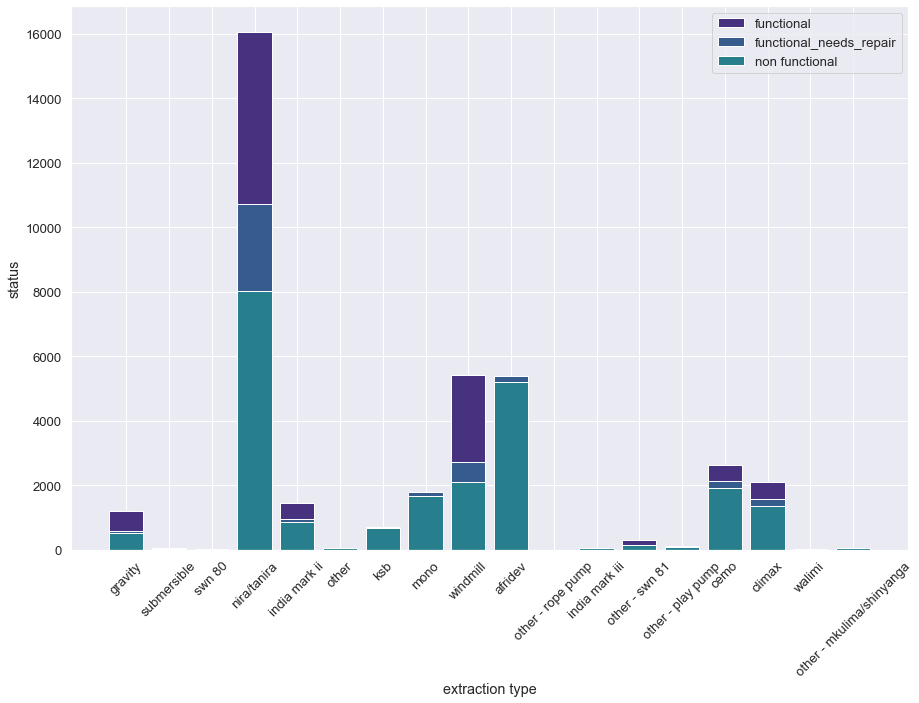

In [196]:
#Assigns the frequency values
functional = contingency_table.iloc[0][0:18].values
functional_needs_repair = contingency_table.iloc[1][0:18].values
non_functional = contingency_table.iloc[2][0:18].values

#Plots the bar chart
fig = plt.figure(figsize=(15,10))
sns.set(font_scale=1.2)
sns.set_palette('viridis')

categories = ['gravity',
 'submersible',
 'swn 80',
 'nira/tanira',
 'india mark ii',
 'other',
 'ksb',
 'mono',
 'windmill',
 'afridev',
 'other - rope pump',
 'india mark iii',
 'other - swn 81',
 'other - play pump',
 'cemo',
 'climax',
 'walimi',
 'other - mkulima/shinyanga']
    

p1 = plt.bar(categories, functional, 0.8)
p2 = plt.bar(categories, functional_needs_repair, 0.8, bottom = non_functional)
p3 = plt.bar(categories, non_functional, 0.8)
plt.xticks(rotation= 45)
plt.legend((p1[0], p2[0], p3[0]), ('functional','functional_needs_repair','non functional'))
plt.xlabel('extraction type')
plt.ylabel('status')
plt.show()

In [200]:
contingency_table = pd.crosstab(
    df.status_group,
    df.extraction_type_class,
    margins = True)
len(contingency_table.columns)

8

In [201]:
contingency_table.columns

Index(['gravity', 'handpump', 'motorpump', 'other', 'rope pump', 'submersible',
       'wind-powered', 'All'],
      dtype='object', name='extraction_type_class')

In [202]:
f_obs = np.array([contingency_table.iloc[0][0:19].values,
                  contingency_table.iloc[1][0:19].values,
                 contingency_table.iloc[2][0:19].values])
f_obs

array([[16048, 10375,  1135,  1029,   293,  3329,    50, 32259],
       [ 2701,   995,   138,   206,    17,   253,     7,  4317],
       [ 8031,  5086,  1714,  5195,   141,  2597,    60, 22824]])

In [203]:
print(stats.chi2_contingency(f_obs)[0:3])

(6931.201640539073, 0.0, 14)


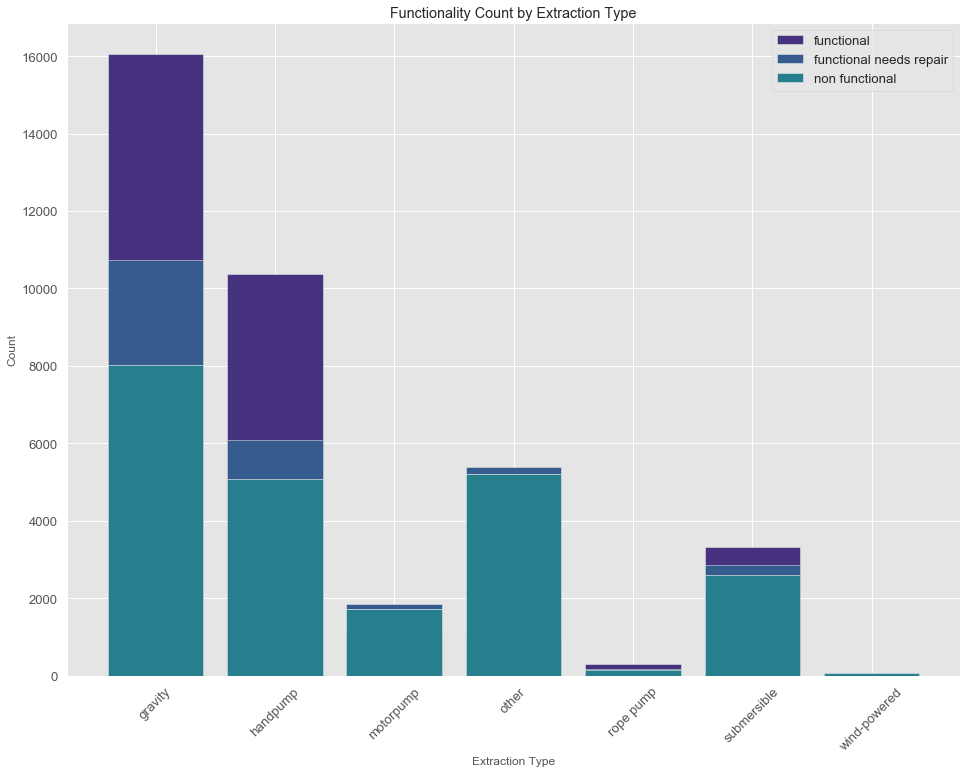

In [238]:
#Assigns the frequency values
functional = contingency_table.iloc[0][0:7].values
functional_needs_repair = contingency_table.iloc[1][0:7].values
non_functional = contingency_table.iloc[2][0:7].values

#Plots the bar chart
fig = plt.figure(figsize=(16,12))
sns.set(font_scale=1.2)
plt.style.use('ggplot')
sns.set_palette('viridis')

categories = ['gravity', 'handpump', 'motorpump', 'other', 'rope pump', 'submersible',
       'wind-powered']
    

p1 = plt.bar(categories, functional, 0.8)
p2 = plt.bar(categories, functional_needs_repair, 0.8, bottom = non_functional)
p3 = plt.bar(categories, non_functional, 0.8)
plt.xticks(rotation= 45)

plt.legend((p1[0], p2[0], p3[0]), ('functional','functional needs repair','non functional'))
plt.title('Functionality Count by Extraction Type')
plt.xlabel('Extraction Type')
plt.ylabel('Count')
plt.show()

filename = 'extraction_type'
fig.savefig(filename)



### Management / Management Group
#### ['management']/['managment_group'] vs ['status_group']


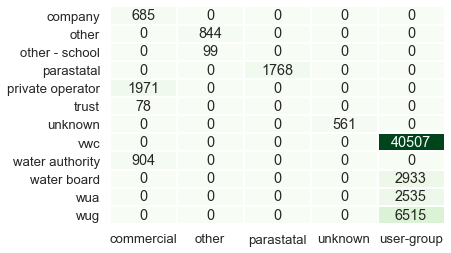

In [300]:
ct = pd.crosstab(df.management, df.management_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Greens')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [301]:
print('mangement_group: ', list(df.management_group.unique()))
print('management: ', list(df.management.unique()))

mangement_group:  ['user-group', 'other', 'commercial', 'parastatal', 'unknown']
management:  ['vwc', 'wug', 'other', 'private operator', 'water board', 'wua', 'company', 'water authority', 'parastatal', 'unknown', 'other - school', 'trust']


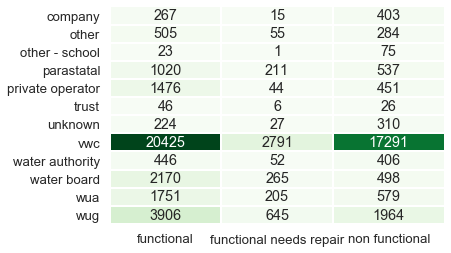

In [302]:
ct = pd.crosstab(df.management, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Greens')
plt.xlabel('')
plt.ylabel('')
plt.show()

Seems that the management subdivisions may prove helpful. I will drop managment_group. 

In [303]:
dropcols = dropcols + ['management_group']

### Payment / Payment Type
#### ['payment']/['payment_type'] vs ['status_group']

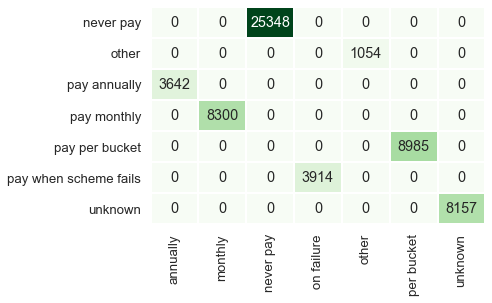

In [304]:
ct = pd.crosstab(df.payment, df.payment_type)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Greens')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [305]:
print('payment_type: ', list(df.payment_type.unique()))
print('payment: ', list(df.payment.unique()))

payment_type:  ['annually', 'never pay', 'per bucket', 'unknown', 'on failure', 'other', 'monthly']
payment:  ['pay annually', 'never pay', 'pay per bucket', 'unknown', 'pay when scheme fails', 'other', 'pay monthly']


This is a trick question. These are exactly the same with slightly different labels. 
payment_type is more concise, so I'll drop payment. 

In [306]:
dropcols = dropcols + ['payment']

### Water Quality / Quality Group
#### ['water_quality']/['quality_group'] vs ['status_group']

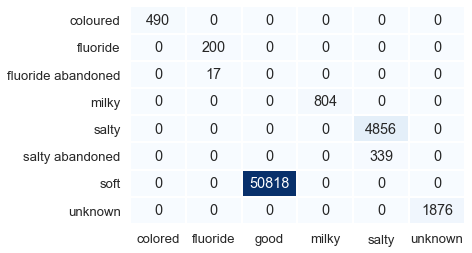

In [307]:
ct = pd.crosstab(df.water_quality, df.quality_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Blues')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [308]:
print('water_quality: ', list(df.water_quality.unique()))
print('quality_group: ', list(df.quality_group.unique()))

water_quality:  ['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured', 'salty abandoned', 'fluoride abandoned']
quality_group:  ['good', 'salty', 'milky', 'unknown', 'fluoride', 'colored']


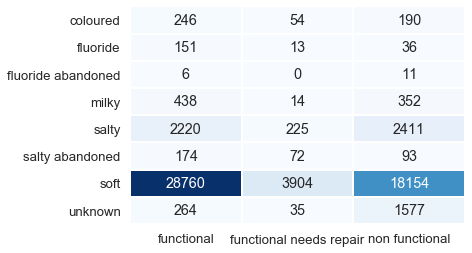

In [309]:
ct = pd.crosstab(df.water_quality, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = 'Blues')
plt.xlabel('')
plt.ylabel('')
plt.show()

It's a small differentation, but I'll keep the additional divides. 

In [310]:
dropcols = dropcols + ['quality_group']

### Quantity / Quantity Group
#### ['quantity']/['quantity_group'] vs ['status_group']

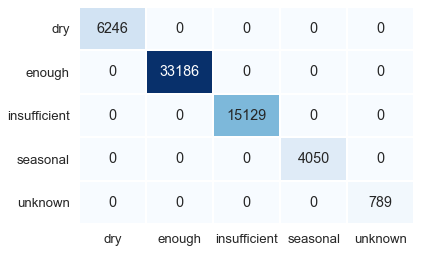

In [311]:
ct = pd.crosstab(df.quantity, df.quantity_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap = "Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [312]:
df.quantity.unique()

array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
      dtype=object)

In [313]:
df.quantity_group.unique()

array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
      dtype=object)

These groups are identical, and we only need one. We aren't data hoarders, so we can drop the quanity group. 

In [314]:
dropcols = dropcols + ['quantity_group']

### Source / Source Type / Source Class
#### ['source']/['source_type']/['source_class'] vs ['status_group']

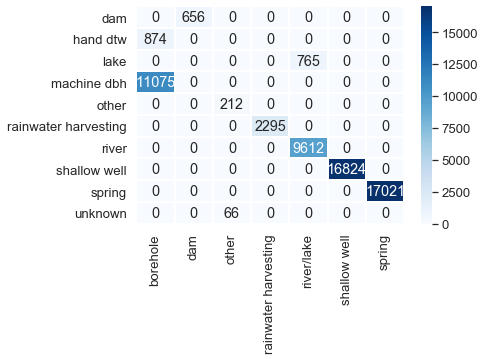

In [315]:
ct = pd.crosstab(df['source'], df['source_type'])
#cross tab allos me to pull just the two groups I'm looking at. 
#additional helpful paramaters are annot (annotated), the linewidths also allows some space. 
sns.heatmap(ct, annot=True, fmt = '.0f', linewidths = 1, cbar = True, cmap= "Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

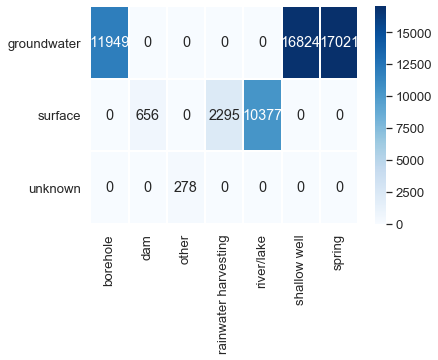

In [316]:
ct = pd.crosstab(df['source_class'], df['source_type'])
#cross tab allos me to pull just the two groups I'm looking at. 
#additional helpful paramaters are annot (annotated), the linewidths also allows some space. 
sns.heatmap(ct, annot=True, fmt = '.0f', linewidths = 1, cbar = True, cmap= "Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

These groups do seem to be quite different. The source column seems to have the most varied classes. 
We can drop source_class and source_type. 

In [317]:
print('source_class: ', list(df.source_class.unique()))
print('source_type:', list(df.source_type.unique()))
print('source: ', list(df.source.unique()))

source_class:  ['groundwater', 'surface', 'unknown']
source_type: ['spring', 'rainwater harvesting', 'dam', 'borehole', 'other', 'shallow well', 'river/lake']
source:  ['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other', 'shallow well', 'river', 'hand dtw', 'lake', 'unknown']


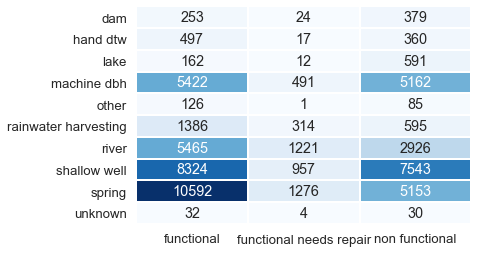

In [318]:
ct = pd.crosstab(df.source, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f', linewidths = 1, cbar = False, cmap= "Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [319]:
dropcols = dropcols + ['source_class', 'source_type']

### Waterpoint Type / Waterpoint Type Group
#### ['waterpoint_type']/['waterpoint_type_group'] vs ['status_group']

Looking at the differneces between these two groups, the waterpoint_type further divides the communal standpipe. 
This sub-group may be beneficial when predicting. 

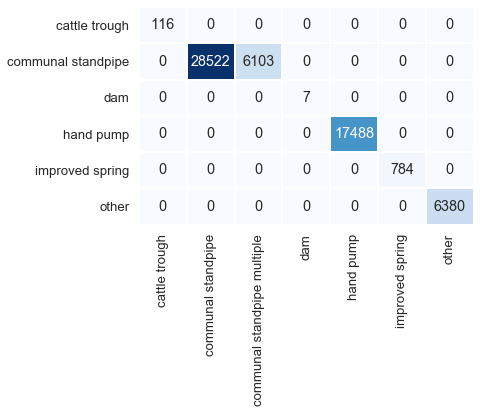

In [320]:
ct = pd.crosstab(df['waterpoint_type_group'], df['waterpoint_type'])
#cross tab allos me to pull just the two groups I'm looking at. 
#additional helpful paramaters are annot (annotated), the linewidths also allows some space. 
sns.heatmap(ct, annot=True, fmt = '.0f', linewidths = 1, cbar = False, cmap= "Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [321]:
print('waterpoint type: ', list(df.waterpoint_type.unique()))
print('waterpoint type group: ', list(df.waterpoint_type_group.unique()))

waterpoint type:  ['communal standpipe', 'communal standpipe multiple', 'hand pump', 'other', 'improved spring', 'cattle trough', 'dam']
waterpoint type group:  ['communal standpipe', 'hand pump', 'other', 'improved spring', 'cattle trough', 'dam']


Above you can see the differences in the break down of the two features. Below we can see that the additional break down does have significance to our target variable. 


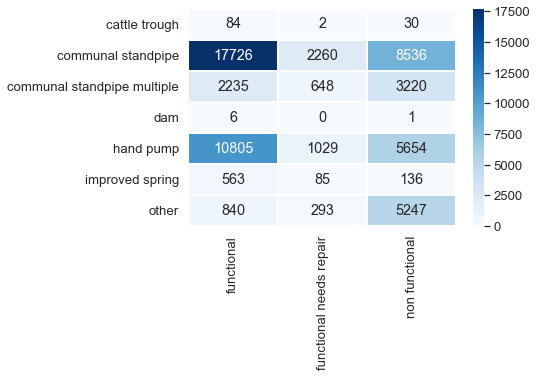

the breakdown between communal standpipe and communal standpipe multiple shows here where we can further break down that waterpoint


In [322]:
ct = pd.crosstab(df.waterpoint_type, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f',linewidths = 1, cmap = 'Blues')
plt.xlabel('')
plt.ylabel('')
plt.show()
print('the breakdown between communal standpipe and communal standpipe multiple shows here where we can further break down that waterpoint')

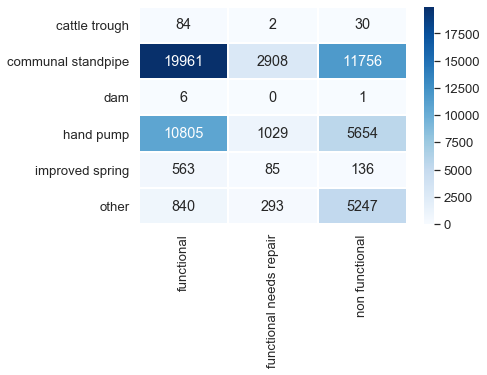

In [323]:
ct = pd.crosstab(df.waterpoint_type_group, df.status_group)
sns.heatmap(ct, annot = True, fmt = '.0f',linewidths = 1, cmap = 'Blues')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
sns.barplot(x = waterpoint_type_group, y = df[df.status_group == 'non functional'], data = df, color = 'viridis')

['id',
 'date_recorded',
 'recorded_by',
 'wpt_name',
 'region_code',
 'ward',
 'scheme_name',
 'extraction_type',
 'extraction_type_group',
 'management_group',
 'payment',
 'quality_group',
 'quantity_group',
 'source_class',
 'source_type',
 'waterpoint_type_group']

### Deal with Bools

In [340]:
df.public_meeting = np.where(df.public_meeting.eq(True), 1, 0)

In [341]:
df.urban = np.where(df.urban.eq(True), 1, 0)

In [342]:
df.permit = np.where(df.permit.eq(True), 1, 0)

In [345]:
dropcols = dropcols + ['waterpoint_type_group']

In [346]:
list(dropcols)

['id',
 'date_recorded',
 'recorded_by',
 'wpt_name',
 'region_code',
 'ward',
 'scheme_name',
 'extraction_type',
 'extraction_type_group',
 'management_group',
 'payment',
 'quality_group',
 'quantity_group',
 'source_class',
 'source_type',
 'waterpoint_type_group',
 'waterpoint_type_group']

In [347]:
# dataframe with these columns removed
subdf = df.drop(dropcols, axis = 1)

In [351]:
subdf.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'num_private', 'basin', 'subvillage', 'region',
       'district_code', 'lga', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year',
       'extraction_type_class', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type', 'status_group', 'basin_lat',
       'basin_long', 'dist_to_basin', 'n_wells_village', 'urban',
       'built_recent'],
      dtype='object')

In [348]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

y = subdf['status_group']
X = subdf.drop('status_group', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20)

In [349]:
df.to_pickle('eda_df.pkl')
pd.to_pickle(X_train, 'X_train.pkl')
pd.to_pickle(X_test, 'X_test.pkl')
pd.to_pickle(y_train, 'y_train.pkl')
pd.to_pickle(y_test, 'y_test.pkl')